# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [1]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

#### Model function
This example consider the simple additive example.

In [2]:
from dependence.tests import func_overflow, margins_overflow, var_names_overflow, func_sum

test_func = func_sum

#### Dimension and margins
We first define the problem dimension and the margins

In [131]:
if test_func == func_overflow:
    margins = margins_overflow
    dim = len(margins)
else:
    dim = 7
    margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

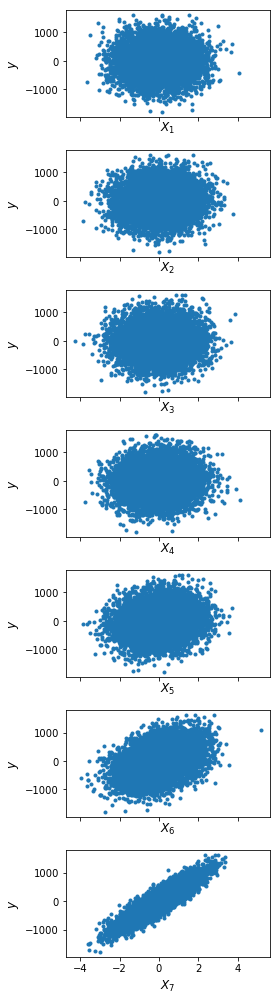

In [132]:
if test_func == func_sum:
    coeficients = np.logspace(0., 3., dim+1, endpoint=False)[1:]

    n_plot = 10000
    x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
    y = test_func(x, coeficients)

    fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
    for i in range(dim):
        ax = axes[i]
        ax.plot(x[:, i], y, '.')
        ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
        ax.set_ylabel(r'$y$', fontsize=12)
    fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [133]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [134]:
from dependence import ConservativeEstimate, quantile_func

alpha = 0.99

if alpha > 0.5: # Maximizing the quantile
    def q_func(x, axis=1):
        return - quantile_func(alpha)(x, axis=axis)
else: # Minimizing
    q_func = quantile_func(alpha)

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

First, we compute the quantile at independence

In [135]:
n = 5000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [136]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -6.09 with a C.O.V at 2.7 %


### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [137]:
structure

array([[1, 0, 0, 0, 0],
       [2, 2, 0, 0, 0],
       [3, 4, 3, 0, 0],
       [4, 3, 4, 4, 0],
       [5, 5, 5, 5, 5]])

In [138]:
structure[3, 1] = 3
structure[2, 1] = 4

structure

array([[1, 0, 0, 0, 0],
       [2, 2, 0, 0, 0],
       [3, 4, 3, 0, 0],
       [4, 3, 4, 4, 0],
       [5, 5, 5, 5, 5]])

In [139]:
structure = quant_estimate.vine_structure

def check_natural_order(structure):
    """
    """
    d = structure.shape[0]
    for i in range(d-1):
        i = 1
        for j in range(i+1):
            parent = [[structure[j, j], structure[i+1, j]], [structure[i+2:d, j].tolist()]]
            col = structure[:, j]
            parent_elements = col[np.setdiff1d(np.arange(j, d), range(j+1, i+1))]

            i_c = i + 1
            if len(parent_elements) > 2:
                n_child = 0
                for j_c in range(i_c+1):
                    possible_child = [[structure[j_c, j_c], structure[i_c+1, j_c]], [structure[i_c+2:d, j_c].tolist()]]
                    col = structure[:, j_c]
                    possible_child_elements = col[np.setdiff1d(np.arange(j_c, d), range(j_c+1, i_c+1))]
                    if len(np.intersect1d(possible_child_elements, parent_elements)) == d-i-1:
                        n_child += 1
                if n_child < 2:
                    return False

    return True

check_natural_order(structure)

True

In [ ]:
from dependence import iterative_vine_minimize

n = 1000
p_max = 4
K = None
verbose = True
grid_type = 'lhs'
n_add_pairs = 1
n_remove_pairs = 0

quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)

worst_quantities, selected_pairs, removed_pairs = iterative_vine_minimize(quant_estimate, 
                                                                          n_input_sample=n,
                                                                          n_dep_param_init=K,
                                                                          p_max=p_max, 
                                                                          grid_type=grid_type, 
                                                                          q_func=q_func,
                                                                          n_add_pairs=n_add_pairs,
                                                                          n_remove_pairs=n_remove_pairs,
                                                                          verbose=True)

In [126]:
%debug

> /local00/home/D58174/GitHub/impact-of-dependence/dependence/iterative_vines.py(390)get_possible_structures()
    388                 print('good:\n{0}'.format(structure))
    389         else:
--> 390             good_structures.remove(tmp)
    391 
    392     print good_structures

ipdb> good_structures
[array([[3, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [2, 2, 0, 0, 0]]), array([[1, 0, 0, 0, 0],
       [3, 2, 0, 0, 0],
       [4, 4, 3, 0, 0],
       [5, 5, 4, 4, 0],
       [2, 3, 5, 5, 5]])]
ipdb> tmp
array([[1, 0, 0, 0, 0],
       [3, 2, 0, 0, 0],
       [4, 4, 3, 0, 0],
       [5, 5, 4, 4, 0],
       [2, 3, 5, 5, 5]])
ipdb> good_structures.remove(0)
*** ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
ipdb> type(good_structures)
<type 'list'>
ipdb> good_structures.remove(tmp)
*** ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or

In [123]:
%debug

> /local00/home/D58174/GitHub/impact-of-dependence/dependence/iterative_vines.py(390)get_possible_structures()
    388                 print('good:\n{0}'.format(structure))
    389         else:
--> 390             good_structures.remove(tmp)
    391 
    392     return good_structures

ipdb> tmp
array([[5, 0, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [3, 3, 2, 0, 0],
       [4, 4, 3, 3, 0],
       [1, 2, 4, 4, 4]])
ipdb> good_structures
[array([[5, 0, 0, 0, 0],
       [2, 2, 0, 0, 0],
       [3, 3, 1, 0, 0],
       [4, 4, 3, 3, 0],
       [1, 1, 4, 4, 4]]), array([[5, 0, 0, 0, 0],
       [2, 1, 0, 0, 0],
       [3, 3, 2, 0, 0],
       [4, 4, 3, 3, 0],
       [1, 2, 4, 4, 4]]), array([[2, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 5, 0, 0, 0]])]
ipdb> q


### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [12]:
K = 1000
grid_type = 'lhs'
quant_estimate = ConservativeEstimate(model_func=test_func, margins=margins, families=families)
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [13]:
min_result = grid_result.min_result
min_result.compute_bootstrap(1000)
boot_std = min_result.bootstrap_sample.std()
boot_mean = min_result.bootstrap_sample.mean()
print('Worst Quantile: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))
print('Cost = %d' % (K*n))

Worst Quantile: -6.87 with a C.O.V at 7.2 %
Cost = 10000000


In [10]:
if dim == 2:
    fig, ax = plt.subplots()
    ax.plot(grid_result.dep_params, grid_result.quantities)